In [1]:
from __future__ import  division
import numpy as np
import pandas as pd
from collections import OrderedDict
import sys
import os
import re
import gzip
import pickle

sys.path.insert(0 , "../codes/")
from LRC.preprocessor_new import  LRC_preprocessor
from LRC.utils import  run_CV, plot_CV_perfomStat
from LRC.classifier import  LogReg_Continuous
from mCpG_to_feature import Gene_Methyldata 

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
############################################################################
## FUNCTION DEFINITONS 

def fit_all_bootstrap(X, y, n_categ_levels, penalty , n_boot=100, alpha=0.95):
    """
    X - (n_obs, n_feature) dataframe. One-hot encoding of categorical variables should occupy first columns
    y- (n_obs,) series of 1, 0 entries. Must have same set of indices as X
    n_categ_levels {int} 
    n_boot {int}
    alpha {float}. alpha for the confidence interval
    """
    ## Fit to data without resampling
    logreg = LogReg_Continuous()
    _ = logreg.fit(X= X.values.copy(), y = y.copy(), lmbda = penalty, n_categ_levels=n_categ_levels )  
    beta_hat = pd.Series( index = X.columns  , data =logreg.beta )
    ## perform bootstrap
    results_bootstrap = []
    for boot_iter in range(n_boot):
        if boot_iter  % 10 ==0:
            print(boot_iter)
        resample_idxs = np.random.choice( X.index.values , size = X.shape[0], replace = True )
        X_resample = X.loc[ resample_idxs , :].copy()
        y_resample = y.loc[resample_idxs].copy()
        logreg = LogReg_Continuous()
        _ = logreg.fit(X= X_resample.values.copy(), y = y_resample.values.copy(),
                           lmbda = penalty , n_categ_levels = n_categ_levels ) 
        beta = pd.Series( index = X.columns, data =logreg.beta )
        results_bootstrap.append(beta)
    ## Compute bootstrap CI
    results_bootstrap = pd.concat(results_bootstrap, axis = 1).transpose() # each row stores results of bootstrap iteration
    lower = np.percentile( results_bootstrap.values , q =((1 - alpha)/2.)*100., axis = 0 )
    upper = np.percentile( results_bootstrap.values , q =(alpha + (1 - alpha)/2.)*100., axis = 0 )
    bootstrap_stats = pd.DataFrame( index= ["beta_hat","CI_lower","CI_upper"], columns = results_bootstrap.columns , 
                                   data = np.stack( [beta_hat[results_bootstrap.columns].values, lower, upper] ) )
    results_bootstrap =  pd.concat( [ results_bootstrap,  bootstrap_stats] ,axis = 0 , keys = ["boot_samples" , "boot_stats"]  )
    return results_bootstrap
    
    
def plot_regcoeff(regCoeff_df,x, y, hue, lower = None, upper = None, row =None, hue_to_color =None, width = 7.5, ax_height = 3, 
                  legend_by_barPlot = False, kwargs_fill_between = {"alpha": 0.3},
                  hue_order = ["DE down vs. rest" , "DE up vs. rest"] , x_order = ["d1" , "d2" , "d3" , "d4"]):
    """Show regression coefficents using line plot for coeffs of numberical variables 
    and bar plots for coeffs of categ variables.
    
    Argument:
        regCoeff_df -  columns must include  x, y, hue, lower , upper 
        hue
    """
    def check_numerical(x):
        try:
            is_numerical = True
            x = float(x)
        except ValueError:
            is_numerical = False
        return is_numerical
    
    hue_vals_unique = regCoeff_df[hue].unique()
    if  hue_to_color is None:
        hue_to_color = { hue_val : plt.cm.tab20(i) for i , hue_val in enumerate(hue_vals_unique )  }
    if row is None:
        n_rows  = 1
    else:
        row_vals_unique = regCoeff_df[row].unique()
        n_rows = len( row_vals_unique )
    fig = plt.figure(figsize = (width, ax_height*n_rows) )
    ## Line plot
    numerical_mask = regCoeff_df[x].map(check_numerical  )
    regCoeff_df_numerical = regCoeff_df.loc[ numerical_mask, :].copy()
    regCoeff_df_categ= regCoeff_df.loc[~numerical_mask, :].copy()
    for row_idx in range(n_rows):
        if n_rows > 1:
            row_val = row_vals_unique[row_idx]
        ## Line plot
        ax = plt.subplot2grid( shape= (n_rows,5) , loc= (row_idx,0), rowspan=1, colspan=4 )
        for hue_val in hue_vals_unique:
            if n_rows > 1:
                mask = (regCoeff_df[hue] == hue_val) & (regCoeff_df[row] ==  row_val)
            else:
                 mask = regCoeff_df[hue] == hue_val
            plotData = regCoeff_df_numerical.loc[ mask, : ].copy()
            ax.plot(plotData[x].values.astype(float) , plotData[y], label = hue_val , color = hue_to_color[hue_val] )
            ax.fill_between(plotData[x].values.astype(float), plotData[lower], plotData[upper], color = hue_to_color[hue_val], **kwargs_fill_between   )
        ax.set_ylabel(y)
        if ax.is_last_row():
            ax.set_xlabel(x )
        if not legend_by_barPlot:
            plt.legend(loc = "lower left" , bbox_to_anchor= (0,1), ncol = 2)
        if n_rows >1:
            ax.set_title("{} = {}".format(row , row_val) )
        ## Bar plot
        ax = plt.subplot2grid( shape= (n_rows,5) , loc= (row_idx,4), rowspan=1, colspan=1 )
        if n_rows > 1:
            plotData = regCoeff_df_categ.loc[regCoeff_df[row] ==  row_val ,: ].copy()
        else:
            plotData = regCoeff_df_categ.copy()
        if lower is not None:
            ax = sns.barplot( data = plotData, x = x, y = y, hue = hue ,palette = hue_to_color, hue_order = hue_order) 
            ## sort by hue and then by x 
            plotData["sort1"] = plotData[hue].apply(lambda x: hue_order.index(x))
            plotData["sort2"] = plotData[x].apply(lambda x: x_order.index(x))
            plotData = plotData.sort_values( by = ["sort2" , "sort1"]).copy() 
            ## add error bars
            bars = sorted( ax.patches, key = lambda x: x.get_x() )
            for bar, lower_val , upper_val in zip(bars ,plotData[lower].values, plotData[upper].values ):
                ax.vlines( bar.get_x() + bar.get_width()/2. , lower_val , upper_val )
        else:
             ax = sns.barplot( data = plotData, x = x, y = y, hue = hue ,palette = hue_to_color) 
        ## aesthetics
        ax.legend_.set_visible(False)
        if legend_by_barPlot:
            plt.legend(loc = "upper left" , bbox_to_anchor= (1,1), ncol = 1)
        ax.set_ylabel("")
        ax.set_xlabel("Day")
        xlabels = ax.get_xticklabels()
        ax.set_xticklabels([ x.get_text().strip("d") for x in xlabels ] )
        
    fig.tight_layout()
    return fig 
    

In [3]:
##########################
## GLOBALS
outdir = "./"
conditions_fit = ["d1", "d2", "d3", "d4" ]
fit_types = ["d.plus0_DE.down_v_rest", "d.plus0_DE.up_v_rest" ]  
penalty_best_list = [0.01 , 0.01 ] 
n_features = 30
extend_rel = 0.2
start = -1*extend_rel
stop = 1.0 + extend_rel
stdz_width = 0.1
multipleEntries = "sum" 
stdz_method =  "med_mad.above" 
tanh_scale = 50.

if not os.path.exists(outdir ):
    os.makedirs(outdir )

### Make `predAll...` dataset

In [4]:
###########################
## LOAD DATA 
##  Load GFF
gtf_file = "../genome/Annotation2/genes.gff"

### Load Genes split by DE transitions
f = open("../processed_RNAseq/DEseq2_removeBatch/timeCourse.geneDEflow.pkl", 'rb')
geneSets_byDay = pickle.load(f)
f.close()

### Load Metagene methylation
geneMethy_byCond_fnames = OrderedDict([("d1", "../gene_methyl/3B13L-d1_mCpG.bayes_gene.extendRel.pklz"),
                                       ("d2", "../gene_methyl/3B13L-d2_mCpG.bayes_gene.extendRel.pklz" ), 
                                       ("d3",  "../gene_methyl/3B13L-d3_mCpG.bayes_gene.extendRel.pklz" ),
                                       ("d4",  "../gene_methyl/3B13L-d4_mCpG.bayes_gene.extendRel.pklz" )])
geneMethy_byCond = OrderedDict([])
for cond , fname in geneMethy_byCond_fnames.items():
    gene_methyl = Gene_Methyldata( gff_file= gtf_file  , feature_type = "gene", 
                               CpG_fns =  None , est_p = "p_bayes", 
                               chroms_allowed = ["chr1", "chr2" , "chr3", "chr4"],
                               est_p_kws = None)
    gene_methyl.load_mCpG_genes(fname )
    gene_methyl.extend_rel = extend_rel 
    geneMethy_byCond[cond] = gene_methyl

Loading gff file ../genome/Annotation2/genes.gff
Loading gff file ../genome/Annotation2/genes.gff
Loading gff file ../genome/Annotation2/genes.gff
Loading gff file ../genome/Annotation2/genes.gff


In [5]:
#################################################################################
## Make full train dataset 
for ft in fit_types: 
    print("working on fit type: {}".format(ft))
    lrc_pp = LRC_preprocessor( n_features = n_features, start = start, stop = stop, stdz_width = stdz_width,
                            multipleEntries =   multipleEntries, stdz_method= stdz_method,  n_process = 12  )
    stdz_params_all= None
    for cond in conditions_fit: 
        print("\tworking on condition {}".format(cond ) )
        gene_methyldata = geneMethy_byCond[cond]
        ## Split gene_methyldata by class 
        if ft == "d.plus0_DE.down_v_rest":
            class0 = OrderedDict([ (g,  pd.DataFrame(data = np.hstack([ gene_methyldata.mCpG_genes[g]['position_rel_scaled'] ,
                                                                        gene_methyldata.mCpG_genes[g]['est_p'][:,None] ]),
                                                     columns = ['position_rel_scaled' , "est_p"] ) ) \
                                  for g in geneSets_byDay[cond]["DE.neither"]['genes'].union( geneSets_byDay[cond]["DE.up"]['genes']) \
                                  if g in gene_methyldata.mCpG_genes.keys()  
                               ])
            class1 = OrderedDict([ (g,  pd.DataFrame(data = np.hstack([ gene_methyldata.mCpG_genes[g]['position_rel_scaled'] ,
                                                                        gene_methyldata.mCpG_genes[g]['est_p'][:,None] ]),
                                             columns = ['position_rel_scaled' , "est_p"] ) ) \
                                  for g in geneSets_byDay[cond]["DE.down"]["genes"]  \
                                  if g in gene_methyldata.mCpG_genes.keys()
                               ])
        elif ft == "d.plus0_DE.up_v_rest":
            class0 = OrderedDict([ (g,  pd.DataFrame(data = np.hstack([ gene_methyldata.mCpG_genes[g]['position_rel_scaled'] ,
                                                                        gene_methyldata.mCpG_genes[g]['est_p'][:,None] ]),
                                                    columns = ['position_rel_scaled' , "est_p"] ) ) \
                                  for g in geneSets_byDay[cond]["DE.neither"]['genes'].union(geneSets_byDay[cond]["DE.down"]['genes'] ) \
                                  if g in gene_methyldata.mCpG_genes.keys()
                                  ])
            class1 = OrderedDict([ (g, pd.DataFrame(data = np.hstack([ gene_methyldata.mCpG_genes[g]['position_rel_scaled'] ,
                                                                        gene_methyldata.mCpG_genes[g]['est_p'][:,None] ]),
                                                    columns = ['position_rel_scaled' , "est_p"] ) ) \
                                  for g in geneSets_byDay[cond]["DE.up"]['genes']  \
                                  if g in gene_methyldata.mCpG_genes.keys()
                                 ])
        else:
            raise ValueError("fit_type value \'{}\' not recognized".format(ft))
     
        lrc_pp.set_stdz_params( [df for cls_dict in [class0, class1] for df in cls_dict.values()], name = cond )
        stdz_params = lrc_pp.stdz_params.copy()
        stdz_params.loc[: , ("condition")] = cond
        if stdz_params_all is None:
            stdz_params_all  = stdz_params.copy()
        else:
            stdz_params_all = pd.concat([ stdz_params_all , stdz_params ], axis = 0)
        ## make standardized dataset  
        lrc_pp.add_data( dataTrain_byClass= OrderedDict([("class0" , class0) , ("class1" , class1 )]) , ## Train and test intentionally the same 
                        dataTest_byClass= OrderedDict([("class0" , class0) , ("class1" , class1 )]) , 
                        nan_to_zero = True,  tanh_scale = tanh_scale ,
                        metadata =  {"fold": 0, "stdz_name": cond})
    ## Get the standardized dataset
    dataset = lrc_pp.dataset.loc[ lrc_pp.dataset.loc[: ,("metaData", "train/test")]  == "train", : ].copy()
    dataset[("feature_categ", "day")] = dataset[("metaData", "stdz_name")].copy()
    dataset= (dataset[["feature_categ","feature", "metaData"]]).rename(columns = {"feature_categ" : "feature"}, level = 0)    
    ## write results
    dataset.to_csv(os.path.join(outdir , "predAll_LRC.in_{}.tsv.gz".format(ft) ), sep = "\t", compression = 'gzip', index = False)
    stdz_params_all.to_csv(os.path.join(outdir , "predAll_LRC.in_stdzParams_{}.tsv.gz".format(ft) ), sep = "\t", compression = 'gzip', index= False) 


working on fit type: d.plus0_DE.down_v_rest
	working on condition d1
	working on condition d2
	working on condition d3
	working on condition d4
working on fit type: d.plus0_DE.up_v_rest
	working on condition d1
	working on condition d2
	working on condition d3
	working on condition d4


## Fit on full data set and get params 

In [14]:
fit_types = ["d.plus0_DE.down_v_rest", "d.plus0_DE.up_v_rest" ]  
outdir = "."
penalty_best_list = [0.01 , 0.01 ] 
alpha = 0.95

In [18]:
beta_best_dict = OrderedDict([])  
n_boot = 100

for ft, penalty_best in zip(fit_types, penalty_best_list ):
    predAll_dataset = pd.read_csv( os.path.join(outdir, "predAll_LRC.in_{}.tsv.gz".format(ft)), sep = "\t", compression = 'gzip', header = [0,1] ) 
    predAll_dataset = predAll_dataset.rename(columns = lambda x: float(x) if (x[0].isdigit() or x[0] == "-") else x , level = 1 )
    ## Cast categorical variable to one-hot
    categ_feature = "day"
    categ_dummies = pd.get_dummies(predAll_dataset[("feature" , categ_feature)])
    n_categ_levels = categ_dummies.shape[1]
    categ_dummies.columns = pd.MultiIndex.from_product( [("feature_categ",) , categ_dummies.columns ] )
    predAll_dataset =pd.concat([ categ_dummies, predAll_dataset.drop(columns=[("feature", categ_feature)]) ] , axis = 1)  
    predAll_dataset = predAll_dataset.rename( columns = {"feature_categ":  "feature"} , level = 0 )
    
    ## Fit to all data and bootstrap estimate CI
    beta_best_dict[ft] = fit_all_bootstrap(X = predAll_dataset["feature"].copy(), y = predAll_dataset[("metaData" , "y")].copy(),
                                       n_categ_levels =  n_categ_levels, penalty = penalty_best , n_boot=n_boot, alpha=0.95)
    


0
10
20
30
40
50
60
70
80
90
0
10
20
30
40
50
60
70
80
90


In [19]:
writeData = pd.concat( [df.loc["boot_stats", :].copy() for df in beta_best_dict.values() ] , keys = beta_best_dict.keys()   )
writeData.index.names = ["Fit_type" ,  "value_type"]
writeData.to_csv( "fitAll_LRC_regressionCoeffs_best.tsv" , sep = "\t")

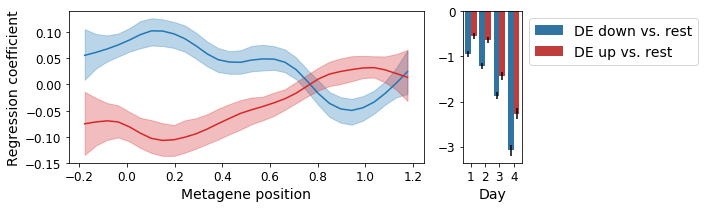

In [20]:
## PLOT
plt.rcParams["legend.fontsize"] = 14
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["axes.labelsize"] = 14

plotData = pd.concat( [df.loc["boot_stats", :].copy() for df in beta_best_dict.values() ] , keys = beta_best_dict.keys()   )
plotData.index.names = ["Fit type" , "value type"]
plotData.columns.name = "Metagene position"
plotData= plotData.stack().unstack("value type").reset_index()

plotData["Fit type"] = plotData["Fit type"].map( {"d.plus0_DE.down_v_rest": "DE down vs. rest", "d.plus0_DE.up_v_rest" : "DE up vs. rest" } )  
plotData = plotData.rename(columns = {"beta_hat" : "Regression coefficient"})

fig = plot_regcoeff(regCoeff_df = plotData.copy(),x = "Metagene position", y = "Regression coefficient", hue = "Fit type", 
                      lower ="CI_lower", upper = "CI_upper", row =None,
                      hue_to_color = {"DE down vs. rest":  (0.12156862745098039, 0.4666666666666667, 0.7058823529411765) , ## blue 
                                      'DE up vs. rest' : (0.8392156862745098, 0.15294117647058825, 0.1568627450980392) } ,  ## red
                      width = 7.5, ax_height = 3, 
                      legend_by_barPlot = True, kwargs_fill_between = {"alpha": 0.3} )
fig.savefig( "fitAll_LRC_regressionCoeffs_best.pdf" , format = "pdf" , bbox_inches = "tight" )

### Plot fits to full dataset for a range of penalties ( for illustration ) 

In [5]:
fit_types = ["d.plus0_DE.down_v_rest", "d.plus0_DE.up_v_rest" ]  
outdir = "."
penalties = np.logspace( -4, -1, base = 10, num= 4) ##-4
n_boot = 100

In [7]:
beta_dict = OrderedDict([ (ft , OrderedDict([])  ) for ft in fit_types  ])

for ft in fit_types:
    
    ## Load data
    predAll_dataset = pd.read_csv( os.path.join(outdir, "predAll_LRC.in_{}.tsv.gz".format(ft)), sep = "\t", compression = 'gzip', header = [0,1] ) 
    predAll_dataset = predAll_dataset.rename(columns = lambda x: float(x) if (x[0].isdigit() or x[0] == "-") else x , level = 1 )
    ## Cast categoriccal variable to one-hot
    categ_feature = "day"
    categ_dummies = pd.get_dummies(predAll_dataset[("feature" , categ_feature)])
    n_categ_levels = categ_dummies.shape[1]
    categ_dummies.columns = pd.MultiIndex.from_product( [("feature_categ",) , categ_dummies.columns ] )
    predAll_dataset =pd.concat([ categ_dummies, predAll_dataset.drop(columns=[("feature", categ_feature)]) ] , axis = 1)  
    predAll_dataset = predAll_dataset.rename( columns = {"feature_categ":  "feature"} , level = 0 )
    ## Fit 
    for penalty in penalties:
        beta_dict[ft][penalty] = fit_all_bootstrap(X = predAll_dataset["feature"].copy(), y = predAll_dataset[("metaData" , "y")].copy(),
                                       n_categ_levels =  n_categ_levels, penalty = penalty , n_boot=n_boot, alpha=0.95)
    

0
10
20
30
40
50
60
70
80
90
0
10
20
30
40
50
60
70
80
90
0
10
20
30
40
50
60
70
80
90
0
10
20
30
40
50
60
70
80
90
0
10
20
30
40
50
60
70
80
90
0
10
20
30
40
50
60
70
80
90
0
10
20
30
40
50
60
70
80
90
0
10
20
30
40
50
60
70
80
90


In [8]:
writeData = pd.concat( [df.loc["boot_stats", :].copy() for penalty_dict in beta_dict.values() for  df in penalty_dict.values()],
                     keys= [ (ft, penalty) for ft, penalty_dict in beta_dict.items() for penalty in penalty_dict.keys()  ] , axis = 0  )
writeData.index.names = ["Fit_type" , "penalty",  "value_type"]
writeData.to_csv( "fitAll_LRC_regressionCoeffs_penalty.all.tsv" , sep = "\t")

In [9]:
plotData = pd.concat( [df.loc["boot_stats", :].copy() for penalty_dict in beta_dict.values() for  df in penalty_dict.values()],
                     keys= [ (ft, penalty) for ft, penalty_dict in beta_dict.items() for penalty in penalty_dict.keys()  ] , axis = 0  )

In [10]:
plotData.index.names = ["Fit type" , "penalty", "value type" ]
plotData.columns.name = "Metagene position"
plotData = plotData.stack()
plotData = plotData.unstack("value type")
plotData = plotData.reset_index()
plotData = plotData.rename(columns= {"beta_hat": "Regression coefficient"})
plotData["Fit type"] = plotData["Fit type"].map( {"d.plus0_DE.down_v_rest": "DE down vs. rest", "d.plus0_DE.up_v_rest" : "DE up vs. rest" } )  

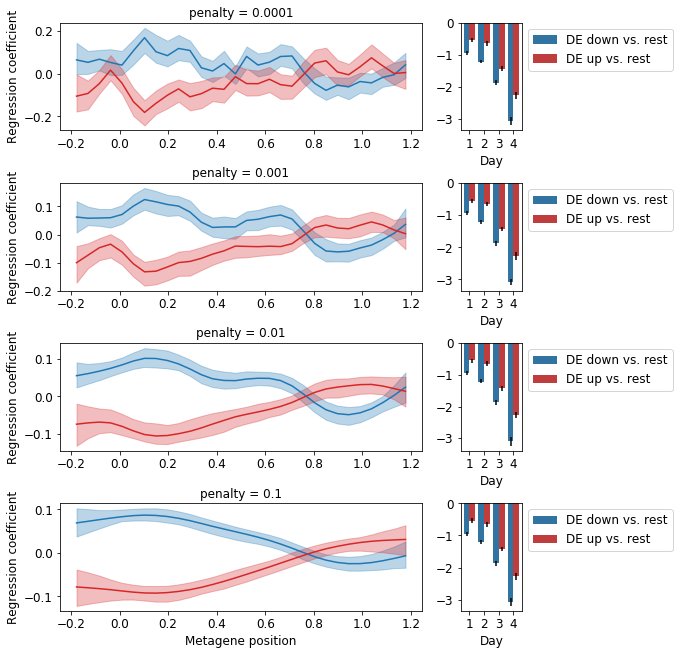

In [11]:
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["axes.labelsize"] = 12

fig = plot_regcoeff(regCoeff_df = plotData.copy(),x = "Metagene position", y = "Regression coefficient", hue = "Fit type", 
                      lower ="CI_lower", upper = "CI_upper", row = "penalty",
                      hue_to_color = {"DE down vs. rest":  (0.12156862745098039, 0.4666666666666667, 0.7058823529411765) , ## blue 
                                      'DE up vs. rest' :  (0.8392156862745098, 0.15294117647058825, 0.1568627450980392) } ,  ## red
                      width = 7.5, ax_height = 2.3, 
                      legend_by_barPlot = True, kwargs_fill_between = {"alpha": 0.3} )

fig.savefig( "fitAll_LRC_regressionCoeffs_penalty.all.pdf" , format = "pdf" , bbox_inches = "tight" )